In [1]:
#Load Importance sampling functions
import sys
sys.path.append('../src')

In [2]:
import datetime, zarr, dask, rasterio as rio, rioxarray as rxr, pandas as pd, rasterstats, tqdm, pathlib, geopandas as gpd, matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal, truncnorm
import plotnine as pn
import os
import subprocess
import importlib
import pyDOE2
from tqdm import tqdm

from transpose import *
from utils import *
from evaluation import *

<h5>Download Data</h5>

In [ ]:
#Download data from AWS
#1. In terminal - 
    # curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    # unzip awscliv2.zip
    # sudo ./aws/install
#3. In terminal inside docker type - aws configure
#4. Add key provided by admin and set region to us-west-2 and output format to json

#Duwamish S3 URL for tif files 
s3_url = "s3://importance-sampling-sst/Trinity/"
local_dir = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity"
os.makedirs(local_dir)
subprocess.run(["aws","s3","cp",s3_url,local_dir,"--recursive"], check = True)

In [3]:
#Locate data
path_sp_watershed = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/geojson/trinity.geojson"
path_sp_domain = "/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/geojson/trinity-transpo-area-v01.geojson"

path_storm = pathlib.Path('/workspaces/Importance-Sampling-for-SST/data/0_source/Trinity/catalog')
df_storms = pd.read_pickle(path_storm/'catalog.pkl')

In [4]:
#Load shapefiles and match projection with rasters
sp_watershed = gpd.read_file(path_sp_watershed)
sp_watershed = match_crs_to_raster(sp_watershed, df_storms['path'].iloc[0])

sp_domain = gpd.read_file(path_sp_domain)
sp_domain = match_crs_to_raster(sp_domain, df_storms['path'].iloc[0])

Reprojecting polygon from EPSG:4326 to EPSG:5070...
Reprojecting polygon from EPSG:4326 to EPSG:5070...


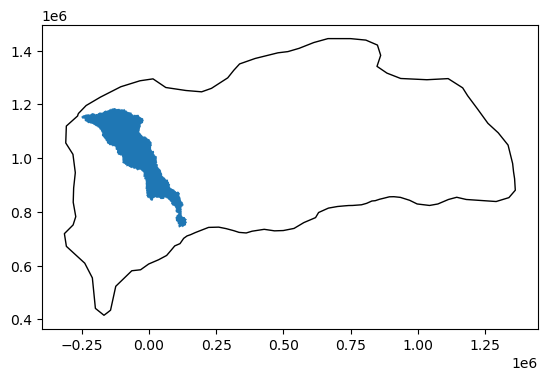

In [5]:
sp_watershed.plot()
sp_domain.plot(ax=plt.gca(),facecolor="none")
plt.show()

In [6]:
v_watershed_stats = get_sp_stats(sp_watershed)
v_domain_stats = get_sp_stats(sp_domain)
print(v_watershed_stats, v_domain_stats)

minx       -2.528011e+05
miny        7.420917e+05
maxx        1.406649e+05
maxy        1.186560e+06
x          -4.742350e+04
y           1.019272e+06
range_x     3.934660e+05
range_y     4.444687e+05
area_km2    6.506943e+04
Name: 0, dtype: float64 minx       -3.150469e+05
miny        4.155483e+05
maxx        1.362324e+06
maxy        1.444762e+06
x           4.456539e+05
y           1.016893e+06
range_x     1.677371e+06
range_y     1.029214e+06
area_km2    1.285695e+06
Name: 0, dtype: float64


In [7]:
dist_x = truncnorm(**truncnorm_params(v_watershed_stats.x, v_watershed_stats.range_x*1, v_domain_stats.minx, v_domain_stats.maxx))
dist_y = truncnorm(**truncnorm_params(v_watershed_stats.y, v_watershed_stats.range_y*1, v_domain_stats.miny, v_domain_stats.maxy))

In [ ]:
# Set simulation parameters
lam = 10                   # average number of storms per year
n_full = 10000            # number of years to simulate
n_part = 1000

# Run the simulations
df_full_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_full, method = 'uniform')
df_full_monte = get_return_period(df_full_monte)

df_part_monte = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'uniform')
df_part_monte = get_return_period(df_part_monte)

df_part_is = simulate_years(df_storms,v_domain_stats,sp_watershed,lam,n_part, method = 'truncnorm',dist_x = dist_x, dist_y = dist_y)
df_part_is = get_return_period(df_part_is)

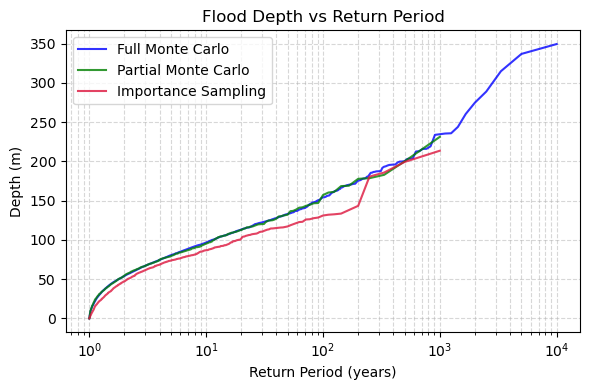

In [15]:
# Plot Return Period vs Depth with better colors
plt.figure(figsize=(6, 4))

plt.semilogx(df_full_monte['return_period'], df_full_monte['depth'],
             linestyle='-', color='blue', alpha=0.8, label='Full Monte Carlo')

plt.semilogx(df_part_monte['return_period'], df_part_monte['depth'],
             linestyle='-', color='green', alpha=0.8, label='Partial Monte Carlo')

plt.semilogx(df_part_is['return_period'], df_part_is['depth'],
             linestyle='-', color='crimson', alpha=0.8, label='Importance Sampling')

plt.xlabel('Return Period (years)')
plt.ylabel('Depth (m)')
plt.title('Flood Depth vs Return Period')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

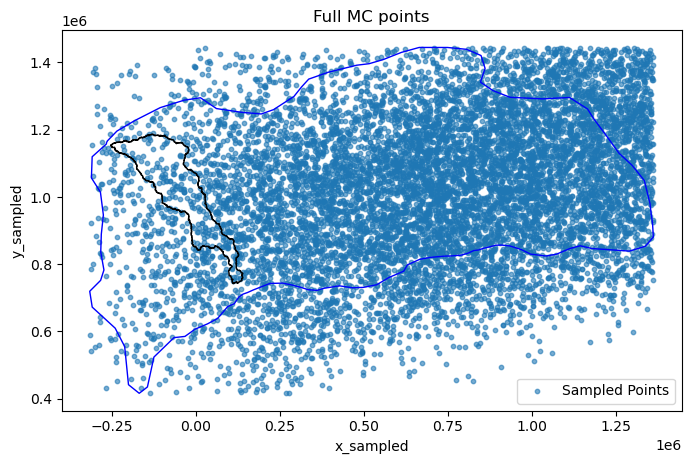

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
df_full_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Full MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

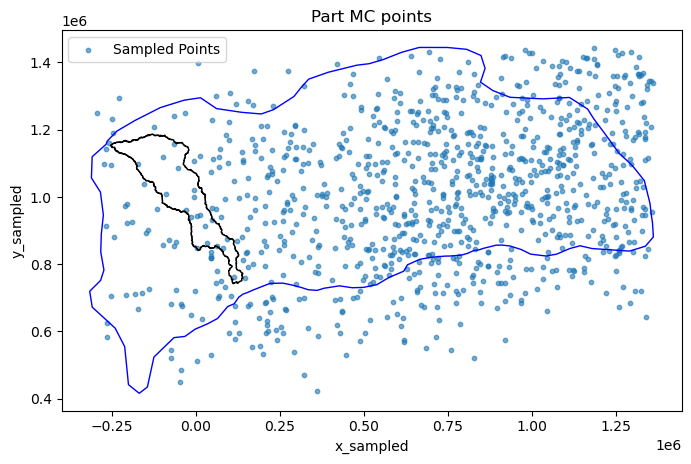

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_monte.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("Part MC points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

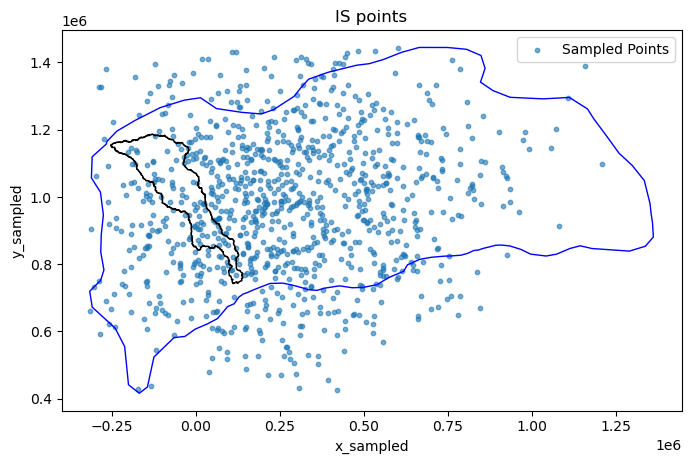

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
df_part_is.plot.scatter(x="x_sampled", y="y_sampled", s=10, alpha=0.6, ax=ax, label="Sampled Points")
plt.title("IS points")
sp_watershed.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, label="Watershed")
sp_domain.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, label="Domain")
plt.show()

In [19]:
df_part_is

,name,path,x,y,x_sampled,y_sampled,weight,prob,x_del,y_del,depth,intersected,prob_exceed,return_period
0,20160309,/workspaces/Importance-Sampling-for-SST/data/0...,308544.311202,1.011244e+06,811789.786864,1.012063e+06,3.860827,0.613152,5.032455e+05,818.636278,213.575607,1,0.000999,1001.000000
1,20151023,/workspaces/Importance-Sampling-for-SST/data/0...,113886.577846,9.291442e+05,130004.013516,8.011168e+05,0.444233,0.002001,1.611744e+04,-128027.448729,199.303879,1,0.001998,500.500000
2,20170826,/workspaces/Importance-Sampling-for-SST/data/0...,86365.990583,7.935938e+05,310411.829256,6.143961e+05,0.814567,0.089958,2.240458e+05,-179197.700390,185.752548,1,0.002997,333.666667
3,20160309,/workspaces/Importance-Sampling-for-SST/data/0...,308544.311202,1.011244e+06,571633.402382,1.061148e+06,1.231965,0.165171,2.630891e+05,49903.586795,180.670975,1,0.003996,250.250000
4,20151023,/workspaces/Importance-Sampling-for-SST/data/0...,113886.577846,9.291442e+05,595496.438557,8.110509e+05,1.508574,0.238868,4.816099e+05,-118093.385199,143.377609,1,0.004995,200.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20120916,/workspaces/Importance-Sampling-for-SST/data/0...,599000.005494,1.038608e+06,482446.376059,1.434899e+06,1.364033,0.310703,-1.165536e+05,396290.826560,0.302349,1,0.995005,1.005020
996,20080912,/workspaces/Importance-Sampling-for-SST/data/0...,190958.383987,9.249282e+05,-76064.473486,9.838117e+05,0.357829,0.050093,-2.670229e+05,58883.508513,0.071606,1,0.996004,1.004012
997,20050923,/workspaces/Importance-Sampling-for-SST/data/0...,400094.558919,1.017357e+06,-66102.393698,1.181499e+06,0.380680,0.153744,-4.661970e+05,164142.394764,0.000000,1,0.997003,1.003006
998,19890613,/workspaces/Importance-Sampling-for-SST/data/0...,460174.267620,1.032282e+06,19843.276251,1.099943e+06,0.366980,0.009693,-4.403310e+05,67661.042606,0.000000,1,0.998002,1.002002
